# Introduction

The purpose of this project is to provide marketing insights for game developers and/or publishers. Better understanding their market will allow for more accurate forecasting of game sales and revenue, can help guide game development objectives, or create opportunties for targeted advertising. These insights are intended to be drawn from a categorization of existing player profiles across three of the most common gaming platforms: Steam (PC), Xbox, and Playstation. The categorization will be computed using an unsupervised learning model trained on a dataset of player profiles downloaded from the "Gaming Profiles 2025" Kaggle database found here: "https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox/code".

# Preprocessing and Feature Engineering

The raw dataset is relatively small (4 GB) and contains features that are irrelevant or initially in a useless format. Because of this, extensive feature engineering is required to provide meaningful insights from a categorical analysis. Some preprocessing is also needed to handle issues such as: missing values, datatype conversions, outlier detection, and data standardization. The final result is three dataframes, one for each platform, containing several useful player profile features that can be used to train the model.

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_theme()
sns.set(font_scale=1.5)

In [3]:
# Data is loaded directly into three dictionaries
Steam = {}
Steam_dir = "/kaggle/input/gaming-profiles-2025-steam-playstation-xbox/steam/"
for file in os.listdir(Steam_dir):
    Steam[file[:-4]] = pd.read_csv(Steam_dir+file)
Steam_keys = list(Steam.keys())

Xbox = {}
Xbox_dir = "/kaggle/input/gaming-profiles-2025-steam-playstation-xbox/xbox/"
for file in os.listdir(Xbox_dir):
    Xbox[file[:-4]] = pd.read_csv(Xbox_dir+file)
Xbox_keys = list(Xbox.keys())

PS = {}
PS_dir = "/kaggle/input/gaming-profiles-2025-steam-playstation-xbox/playstation/"
for file in os.listdir(PS_dir):
    PS[file[:-4]] = pd.read_csv(PS_dir+file)
PS_keys = list(PS.keys())
    

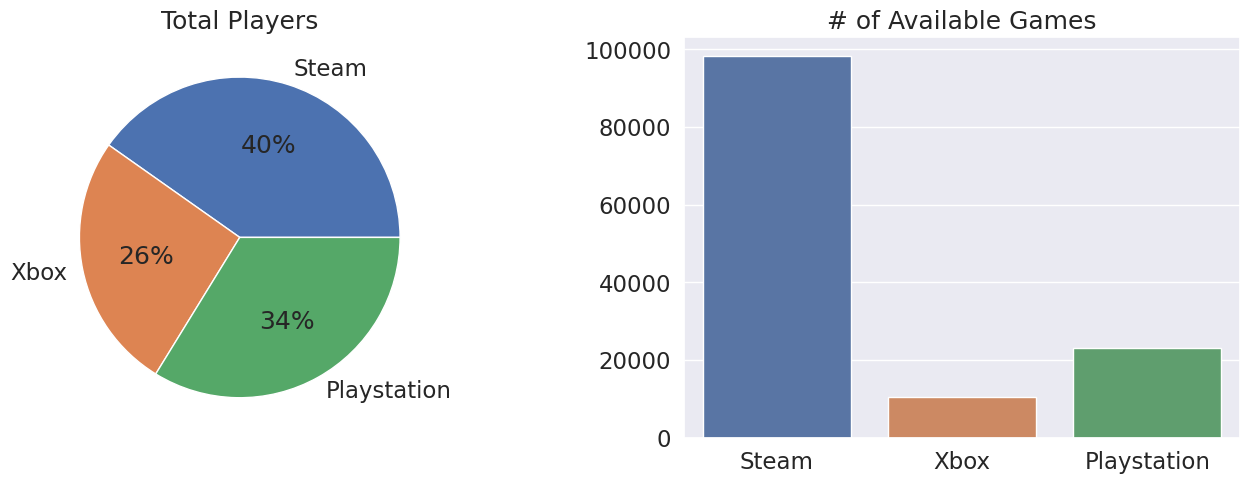

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axes[0].pie([len(Steam["players"]["playerid"].unique()), len(Xbox["players"]["playerid"].unique()),
         len(PS["players"]["playerid"].unique())], labels = ["Steam","Xbox","Playstation"], autopct='%1.0f%%')
axes[0].set_title("Total Players")

data = pd.DataFrame(data = {"Platform": ["Steam","Xbox","Playstation"],
                    "Games": [len(Steam["games"]["gameid"].unique()), len(Xbox["games"]["gameid"].unique()),
                              len(PS["games"]["gameid"].unique())]})

sns.barplot(data = data, x = "Platform", y = "Games", ax = axes[1])
axes[1].set_title("# of Available Games")
axes[1].set(xlabel=None, ylabel=None)

plt.show()

In [5]:
steam_genres_s = Steam["games"]["genres"].dropna().apply(lambda x: np.array(ast.literal_eval(x)))
steam_genres = np.unique(np.concatenate((steam_genres_s.to_numpy())))

steam_genre_count = []
i=0
while i < len(steam_genres):
    genre = steam_genres[i]
    count = steam_genres_s.apply(lambda x: genre in x).sum()/len(Steam["games"]["gameid"].unique())*100
    if count > 1:
        steam_genre_count.append(count)
    else:
        steam_genres = np.delete(steam_genres, i)
        i-=1
    i+=1
        
    
Xbox_genres_s = Xbox["games"]["genres"].dropna().apply(lambda x: np.array(ast.literal_eval(x)))
Xbox_genres = np.unique(np.concatenate((Xbox_genres_s.to_numpy())))

Xbox_genre_count = []
i=0
while i < len(Xbox_genres):
    genre = Xbox_genres[i]
    count = Xbox_genres_s.apply(lambda x: genre in x).sum()/len(Xbox["games"]["gameid"].unique())*100
    if count > 1:
        Xbox_genre_count.append(count)
    else:
        Xbox_genres = np.delete(Xbox_genres, i)
        i-=1
    i+=1

PS_genres_s = PS["games"]["genres"].dropna().apply(lambda x: np.array(ast.literal_eval(x)))
PS_genres = np.unique(np.concatenate((PS_genres_s.to_numpy())))

PS_genre_count = []
i=0
while i < len(PS_genres):
    genre = PS_genres[i]
    count = PS_genres_s.apply(lambda x: genre in x).sum()/len(PS["games"]["gameid"].unique())*100
    if count > 1:
        PS_genre_count.append(count)
    else:
        PS_genres = np.delete(PS_genres, i)
        i-=1
    i+=1

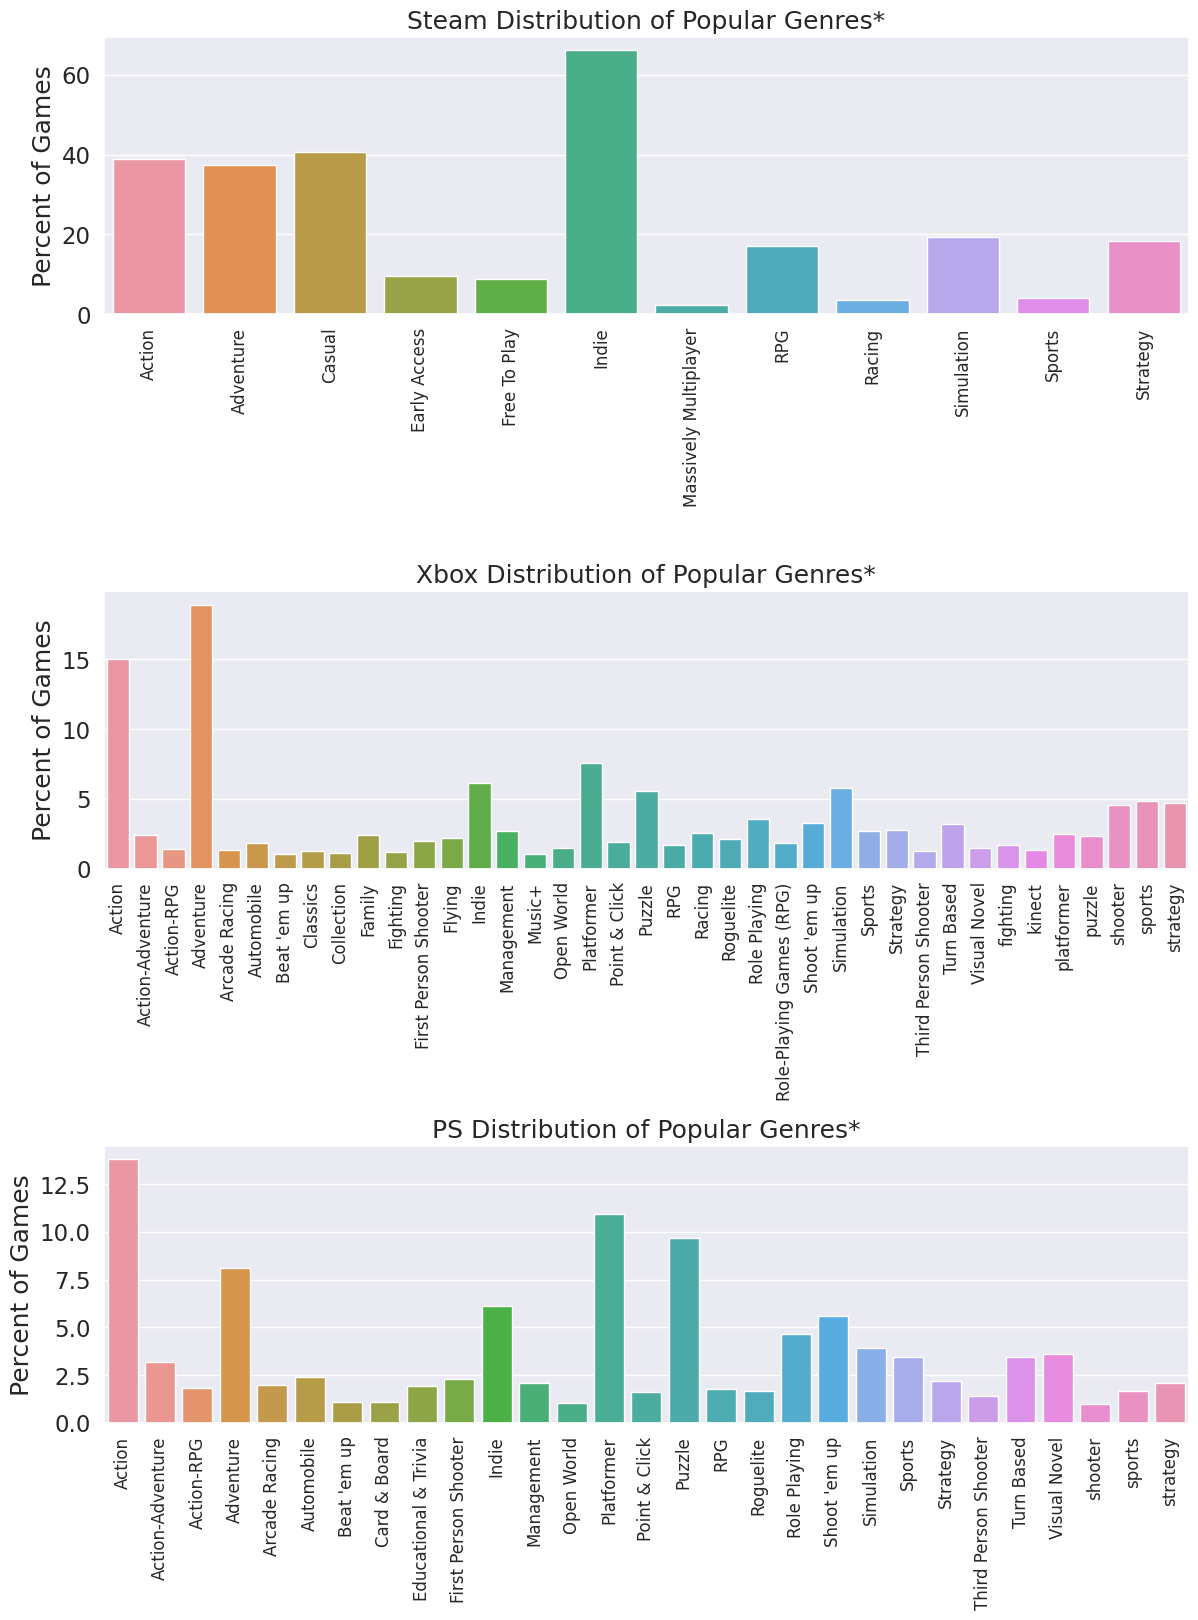

* Popular genres cover greater than 1% of all games on the platform
Some games are classified by more than one genre


In [6]:
fig, axes = plt.subplots(3,1, figsize=(14, 18))
plt.subplots_adjust(hspace=1)

data = dict(zip(steam_genres, steam_genre_count))
df = pd.DataFrame(list(data.items()), columns=['Genre', 'Percent of Games'])
sns.barplot(x = "Genre", y="Percent of Games", data=df, ax = axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='center')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].set_title("Steam Distribution of Popular Genres*")
axes[0].set(xlabel=None)

data = dict(zip(Xbox_genres, Xbox_genre_count))
df = pd.DataFrame(list(data.items()), columns=['Genre', 'Percent of Games'])
sns.barplot(x = "Genre", y="Percent of Games", data=df, ax = axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, ha='center')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].set_title("Xbox Distribution of Popular Genres*")
axes[1].set(xlabel=None)

data = dict(zip(PS_genres, PS_genre_count))
df = pd.DataFrame(list(data.items()), columns=['Genre', 'Percent of Games'])
sns.barplot(x = "Genre", y="Percent of Games", data=df, ax = axes[2])
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90, ha='center')
axes[2].tick_params(axis='x', labelsize=12)
axes[2].set_title("PS Distribution of Popular Genres*")
axes[2].set(xlabel=None)

plt.show()

print("* Popular genres cover greater than 1% of all games on the platform\nSome games are classified by more than one genre")

In [7]:
# Need some fine tuning of raw genre lists because of duplicates and for more generlized genre categories

Steam_genres_refined = steam_genres
Xbox_genres_refined = np.char.lower(np.delete(Xbox_genres, [1,2,11,23,24,29,32,34,35,37,38]))
PS_genres_refined = np.char.lower(np.delete(PS_genres, [1,2,9,18,23,27,28]))

In [8]:
# initialize player characteristics table

Steam_player_char = Steam["players"][["playerid"]].set_index('playerid')
Xbox_player_char = Xbox["players"][["playerid"]].set_index('playerid')
PS_player_char = PS["players"][["playerid"]].set_index('playerid')

In [9]:
# Add friend count through join on friends table

Steam["friends"]["friends count"] = Steam["friends"]["friends"].fillna("").apply(lambda x: int(len(x)/21))
Steam_player_char = Steam_player_char.join(Steam["friends"].set_index('playerid')[["friends count"]], on="playerid")

In [10]:
# Add game count through join on purchased games table.
# Do not count any games from player game library if game is not listed in databse

def filter_games(game_list, Dict):
    to_delete = []
    index = Dict["games"].index
    for i in range(len(game_list)):
        if game_list[i] not in index:
            to_delete.append(i)
    return np.delete(game_list, to_delete)

def filter_Steam_games(game_list):
    return filter_games(game_list, Steam)

def filter_Xbox_games(game_list):
    return filter_games(game_list, Xbox)

def filter_PS_games(game_list):
    return filter_games(game_list, PS)

Steam["games"] = Steam["games"].set_index("gameid")
Xbox["games"] = Xbox["games"].set_index("gameid")
PS["games"] = PS["games"].set_index("gameid")
Steam["purchased_games"] = Steam["purchased_games"].dropna()

Steam["purchased_games"]["library_array"] = Steam["purchased_games"].fillna('[]')["library"].apply(lambda x: np.array(ast.literal_eval(x)))
Steam["purchased_games"]["library_array"] = Steam["purchased_games"]["library_array"].apply(filter_Steam_games)
Steam["purchased_games"]["games count"] = Steam["purchased_games"]["library_array"].apply(lambda x: len(x))
Steam_player_char = Steam_player_char.join(Steam["purchased_games"].set_index('playerid')[["games count"]], on="playerid")

Xbox["purchased_games"]["library_array"] = Xbox["purchased_games"]["library"].apply(lambda x: np.array(ast.literal_eval(x)))
Xbox["purchased_games"]["library_array"] = Xbox["purchased_games"]["library_array"].apply(filter_Xbox_games)
Xbox["purchased_games"]["games count"] = Xbox["purchased_games"]["library_array"].apply(lambda x: len(x))
Xbox_player_char = Xbox_player_char.join(Xbox["purchased_games"].set_index('playerid')[["games count"]], on="playerid")

PS["purchased_games"]["library_array"] = PS["purchased_games"]["library"].apply(lambda x: np.array(ast.literal_eval(x)))
PS["purchased_games"]["library_array"] = PS["purchased_games"]["library_array"].apply(filter_PS_games)
PS["purchased_games"]["games count"] = PS["purchased_games"]["library_array"].apply(lambda x: len(x))
PS_player_char = PS_player_char.join(PS["purchased_games"].set_index('playerid')[["games count"]], on="playerid")

In [11]:
# It appears that some data may be missing as there are a significant # of players with no games.
# For a cleaner analysis we will remove any players with no games in their library.

Steam_player_char =  Steam_player_char[Steam_player_char["games count"] != 0].dropna()

Xbox_player_char =  Xbox_player_char[Xbox_player_char["games count"] != 0].dropna()

PS_player_char =  PS_player_char[PS_player_char["games count"] != 0].dropna()

In [12]:
# Calcuate age of each game

Steam["games"]["release_date_datetime"] = pd.to_datetime(Steam["games"]["release_date"], format='%Y-%m-%d')
today =date.today()
Steam["games"]["game age"] = Steam["games"]["release_date_datetime"].apply(lambda x: (today - x.date()).days)

Xbox["games"]["release_date_datetime"] = pd.to_datetime(Xbox["games"]["release_date"], format='%Y-%m-%d')
today =date.today()
Xbox["games"]["game age"] = Xbox["games"]["release_date_datetime"].apply(lambda x: (today - x.date()).days)

PS["games"]["release_date_datetime"] = pd.to_datetime(PS["games"]["release_date"], format='%Y-%m-%d')
today =date.today()
PS["games"]["game age"] = PS["games"]["release_date_datetime"].apply(lambda x: (today - x.date()).days)

In [13]:
# Estimate age and activity of players based on age of games in player library
    
def ages(game_list, Dict):
    df = pd.DataFrame(index = game_list)
    return df.join(Dict["games"]["game age"]).dropna()["game age"].to_numpy()

def Steam_ages(game_list):
    return ages(game_list, Steam)

def Xbox_ages(game_list):
    return ages(game_list, Xbox)

def PS_ages(game_list):
    return ages(game_list, PS)

Steam["purchased_games"]["age_array"] = Steam["purchased_games"]["library_array"].apply(Steam_ages)
Steam["purchased_games"]["min_age"] = Steam["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.min(x)))
Steam["purchased_games"]["max_age"] = Steam["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.max(x)))
Steam["purchased_games"]["mean_age"] = Steam["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.mean(x)))
Steam_player_char = Steam_player_char.join(Steam["purchased_games"].set_index('playerid')[["min_age", "max_age", "mean_age"]], on="playerid")

Xbox["purchased_games"]["age_array"] = Xbox["purchased_games"]["library_array"].apply(Xbox_ages)
Xbox["purchased_games"]["min_age"] = Xbox["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.min(x)))
Xbox["purchased_games"]["max_age"] = Xbox["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.max(x)))
Xbox["purchased_games"]["mean_age"] = Xbox["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.mean(x)))
Xbox_player_char = Xbox_player_char.join(Xbox["purchased_games"].set_index('playerid')[["min_age", "max_age", "mean_age"]], on="playerid")

PS["purchased_games"]["age_array"] = PS["purchased_games"]["library_array"].apply(PS_ages)
PS["purchased_games"]["min_age"] = PS["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.min(x)))
PS["purchased_games"]["max_age"] = PS["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.max(x)))
PS["purchased_games"]["mean_age"] = PS["purchased_games"]["age_array"].apply(lambda x: 0 if len(x) == 0 else round(np.mean(x)))
PS_player_char = PS_player_char.join(PS["purchased_games"].set_index('playerid')[["min_age", "max_age", "mean_age"]], on="playerid")


In [14]:
# Need to create representation of genre classes for each player

for genre in steam_genres:
    Steam["games"][genre] = Steam["games"]["genres"].fillna("").apply(lambda x: 1 if genre in x else 0)

Steam["purchased_games"][steam_genres] = 0
for i in Steam["purchased_games"].index:
    Steam["purchased_games"].loc[i, steam_genres] = Steam["games"].loc[Steam["purchased_games"]["library_array"][i]][steam_genres].sum().to_numpy()

Steam_player_char = Steam_player_char.join(Steam["purchased_games"].set_index('playerid')[steam_genres], on="playerid")
Steam_player_char[steam_genres] = Steam_player_char[steam_genres].div(Steam_player_char["games count"], axis = "index")

for genre in Xbox_genres_refined:
    Xbox["games"][genre] = Xbox["games"]["genres"].str.lower().fillna("").apply(lambda x: 1 if genre in x else 0)

Xbox["purchased_games"][Xbox_genres_refined] = 0
for i in Xbox["purchased_games"].index:
    Xbox["purchased_games"].loc[i, Xbox_genres_refined] = Xbox["games"].loc[Xbox["purchased_games"]["library_array"][i]][Xbox_genres_refined].sum().to_numpy()

Xbox_player_char = Xbox_player_char.join(Xbox["purchased_games"].set_index('playerid')[Xbox_genres_refined], on="playerid")
Xbox_player_char[Xbox_genres_refined] = Xbox_player_char[Xbox_genres_refined].div(Xbox_player_char["games count"], axis = "index")

for genre in PS_genres_refined:
    PS["games"][genre] = PS["games"]["genres"].str.lower().fillna("").apply(lambda x: 1 if genre in x else 0)

PS["purchased_games"][PS_genres_refined] = 0
for i in PS["purchased_games"].index:
    PS["purchased_games"].loc[i, PS_genres_refined] = PS["games"].loc[PS["purchased_games"]["library_array"][i]][PS_genres_refined].sum().to_numpy()

PS_player_char = PS_player_char.join(PS["purchased_games"].set_index('playerid')[PS_genres_refined], on="playerid")
PS_player_char[PS_genres_refined] = PS_player_char[PS_genres_refined].div(PS_player_char["games count"], axis = "index")

In [15]:
# Outliers are most extreme is friends count and games count features. The outliers are removed
# MinMaxScalar was chosen to initially provide equal weighting to all feautres.
# Weighting factors are then applied to the scaled data to favor specific features that are more valuable.
# Weighting factors are based on personal knowledge of the general gaming community.
# Weighting factors are kept small as to not over-influence the clustering algorithm used in the next section.

Steam_player_char['z_score'] = np.abs((Steam_player_char['friends count'] - Steam_player_char['friends count'].mean()) / Steam_player_char['friends count'].std())
Steam_player_char = Steam_player_char[Steam_player_char['z_score'] < 3]
Steam_player_char['z_score'] = np.abs((Steam_player_char['games count'] - Steam_player_char['games count'].mean()) / Steam_player_char['games count'].std())
Steam_player_char = Steam_player_char[Steam_player_char['z_score'] < 3].drop(["z_score"], axis = 1)

Xbox_player_char['z_score'] = np.abs((Xbox_player_char['games count'] - Xbox_player_char['games count'].mean()) / Xbox_player_char['games count'].std())
Xbox_player_char = Xbox_player_char[Xbox_player_char['z_score'] < 3].drop(["z_score"], axis = 1)

PS_player_char['z_score'] = np.abs((PS_player_char['games count'] - PS_player_char['games count'].mean()) / PS_player_char['games count'].std())
PS_player_char = PS_player_char[PS_player_char['z_score'] < 3].drop(["z_score"], axis = 1)

Steam_scaler = MinMaxScaler(feature_range=(0, 1))
Steam_weights = np.array([2,2,2,1,1, 1,1,1,2,2,2,2,2,1,1,2,2])

Xbox_scaler = MinMaxScaler(feature_range=(0, 1))
Xbox_weights = np.array([2,2,1,1, 1,1,1,1,1,2,1,1,1,1, 2,1,1,2,2,1,1,2,2,1, 1,1,2,1,1,1,1,1])

PS_scaler = MinMaxScaler(feature_range=(0, 1))
PS_weights = np.array([2,2,1,1, 1,1,1,1,1,1,1,2,1,2, 2,1,1,2,1,1,1,2,1,1, 1,1])

Steam_player_char.columns = np.array(Steam_player_char.columns.to_list())
Xbox_player_char.columns = np.array(Xbox_player_char.columns.to_list())
PS_player_char.columns = np.array(PS_player_char.columns.to_list())

Steam_player_char_T = pd.DataFrame(Steam_scaler.fit_transform(Steam_player_char)*Steam_weights, columns = Steam_player_char.columns.astype(str))
Xbox_player_char_T = pd.DataFrame(Xbox_scaler.fit_transform(Xbox_player_char)*Xbox_weights, columns = Xbox_player_char.columns.astype(str))
PS_player_char_T = pd.DataFrame(PS_scaler.fit_transform(PS_player_char)*PS_weights, columns = PS_player_char.columns.astype(str))

# Modeling



The categorical model is created for each of the three platforms using the common KMeans algorithm. Elbow plots are used to identify an appropriate number of clusters. For comparison, the same number of clusters is chosen for each platform.



In [16]:
# Inertias (WCSS) are calculated for each platform model. Each model uses the same random state to gaurentee comparability.

Steam_inertias = []
Xbox_inertias = []
PS_inertias = []
for k in range(1, 20):
    Steam_kmeans = KMeans(n_clusters=k, random_state=11)
    Steam_kmeans.fit(Steam_player_char_T)
    Steam_inertias.append(Steam_kmeans.inertia_)
    
    Xbox_kmeans = KMeans(n_clusters=k, random_state=11)
    Xbox_kmeans.fit(Xbox_player_char_T)
    Xbox_inertias.append(Xbox_kmeans.inertia_)
    
    PS_kmeans = KMeans(n_clusters=k, random_state=11)
    PS_kmeans.fit(PS_player_char_T)
    PS_inertias.append(PS_kmeans.inertia_)


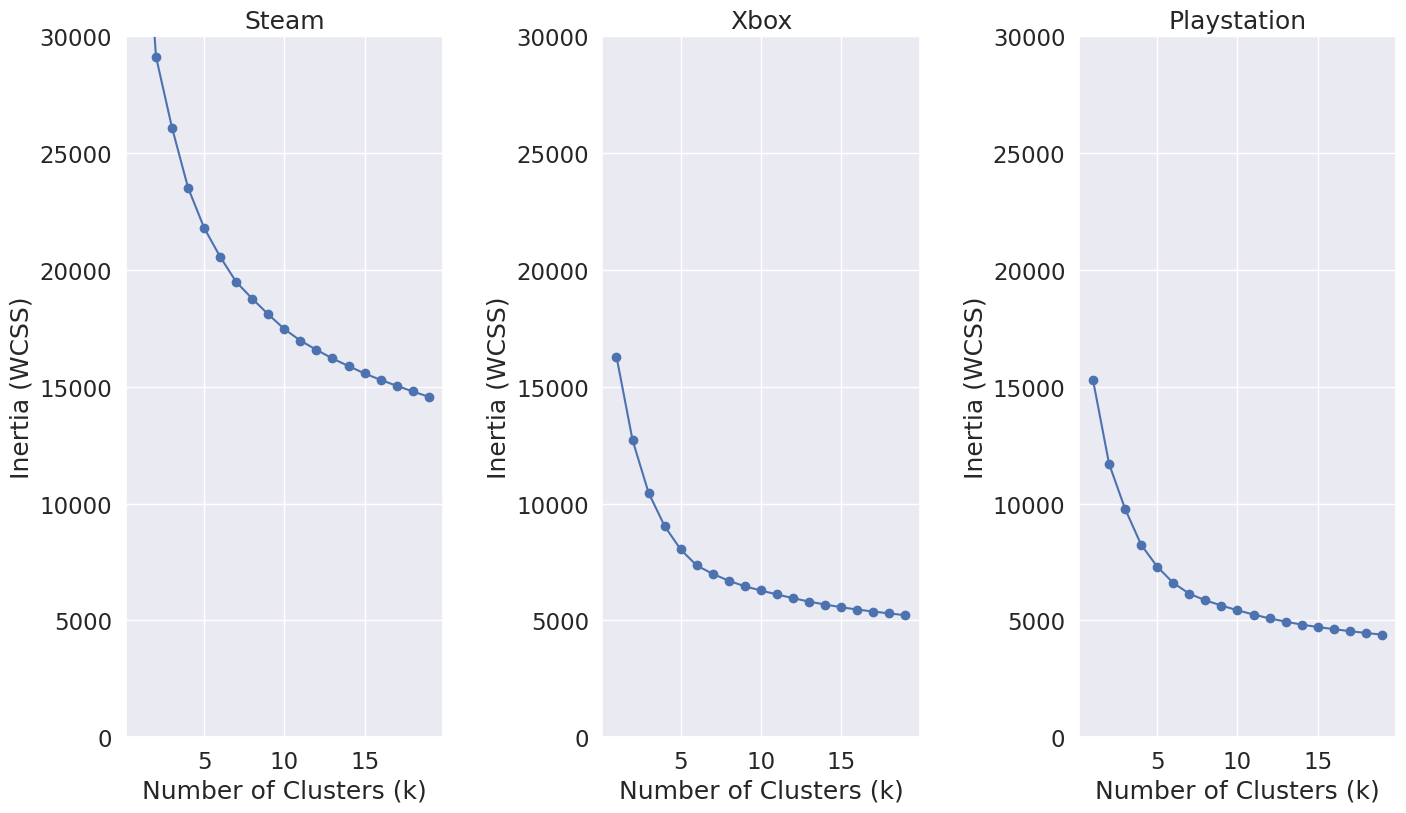

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)

axes[0].plot(range(1, 20), Steam_inertias, marker='o')
axes[0].set_title('Steam')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].grid(True)
axes[0].set_ylim([0, 30000])

axes[1].plot(range(1, 20), Xbox_inertias, marker='o')
axes[1].set_title('Xbox')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia (WCSS)')
axes[1].grid(True)
axes[1].set_ylim([0, 30000])

axes[2].plot(range(1, 20), PS_inertias, marker='o')
axes[2].set_title('Playstation')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Inertia (WCSS)')
axes[2].grid(True)
axes[2].set_ylim([0, 30000])


plt.show()

In [18]:
k = 4

Steam_kmeans = KMeans(n_clusters = k)
Steam_kmeans.fit(Steam_player_char_T)
Steam_player_char_C = Steam_player_char.copy()
Steam_player_char_T_C = Steam_player_char_T.copy()
Steam_player_char_C["cluster"] = Steam_kmeans.labels_
Steam_player_char_T_C["cluster"] = Steam_kmeans.labels_

Xbox_kmeans = KMeans(n_clusters = k)
Xbox_kmeans.fit(Xbox_player_char_T)
Xbox_player_char_C = Xbox_player_char.copy()
Xbox_player_char_T_C = Xbox_player_char_T.copy()
Xbox_player_char_C["cluster"] = Xbox_kmeans.labels_
Xbox_player_char_T_C["cluster"] = Xbox_kmeans.labels_

PS_kmeans = KMeans(n_clusters = k)
PS_kmeans.fit(PS_player_char_T)
PS_player_char_C = PS_player_char.copy()
PS_player_char_T_C = PS_player_char_T.copy()
PS_player_char_C["cluster"] = PS_kmeans.labels_
PS_player_char_T_C["cluster"] = PS_kmeans.labels_

## Steam Model Visualization

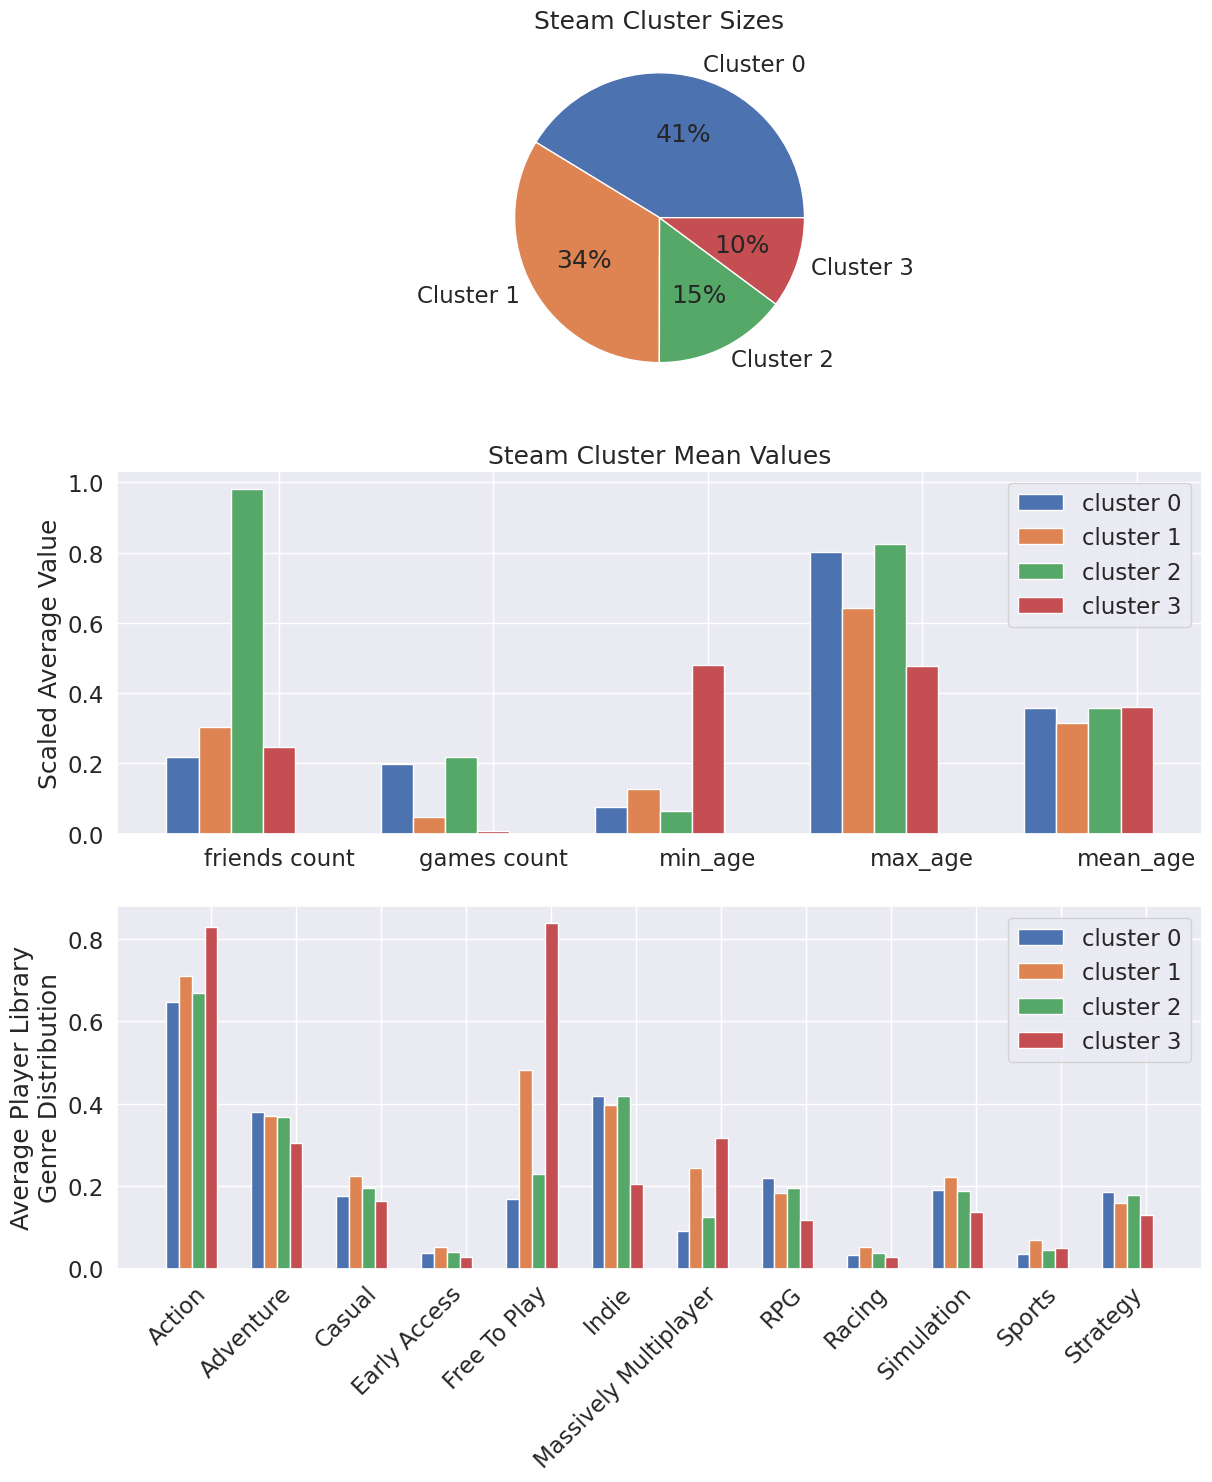

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

grouped = Steam_player_char_T_C.groupby("cluster")["friends count"].count()

axes[0].pie(grouped, labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], autopct='%1.0f%%')
axes[0].set_title("Steam Cluster Sizes")

grouped = Steam_player_char_T_C.groupby("cluster").mean().drop(steam_genres, axis = 1)
width = 0.15
r = np.arange(5)
for i in range(k):
    axes[1].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[1].set_title("Steam Cluster Mean Values")
axes[1].set_ylabel("Scaled Average Value")
axes[1].legend()

grouped = Steam_player_char_C.groupby("cluster").mean()[steam_genres]
width = 0.15
r = np.arange(12)
for i in range(k):
    axes[2].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")
#     axes[2].bar(tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_ylabel("Average Player Library\nGenre Distribution")
axes[2].legend()

plt.show()

## Xbox Model Visualization

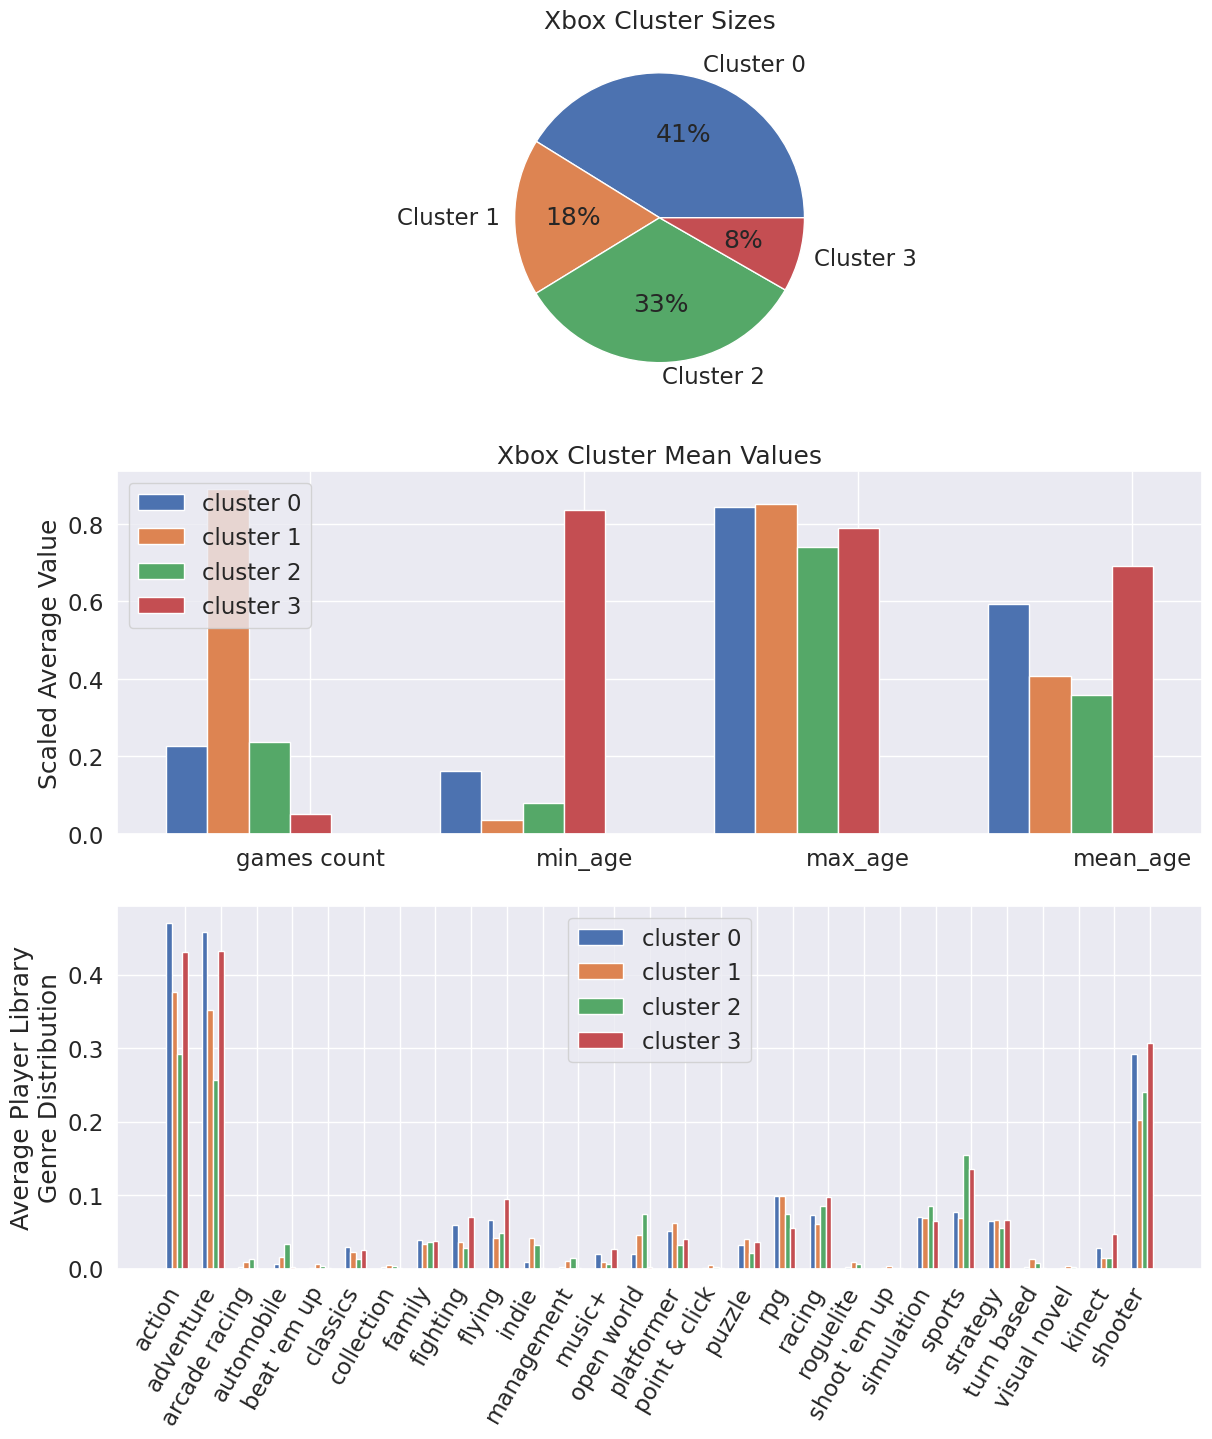

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

grouped = Xbox_player_char_T_C.groupby("cluster")["games count"].count()

axes[0].pie(grouped, labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], autopct='%1.0f%%')
axes[0].set_title("Xbox Cluster Sizes")

grouped = Xbox_player_char_T_C.groupby("cluster").mean().drop(Xbox_genres_refined, axis = 1)
width = 0.15
r = np.arange(4)
for i in range(k):
    axes[1].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[1].set_title("Xbox Cluster Mean Values")
axes[1].set_ylabel("Scaled Average Value")
axes[1].legend()

grouped = Xbox_player_char_C.groupby("cluster").mean()[Xbox_genres_refined]
width = 0.15
r = np.arange(28)
for i in range(k):
    axes[2].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")
#     axes[2].bar(tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=60, ha='right')
axes[2].set_ylabel("Average Player Library\nGenre Distribution")
axes[2].legend()

plt.show()

## Playstation Model Visualization

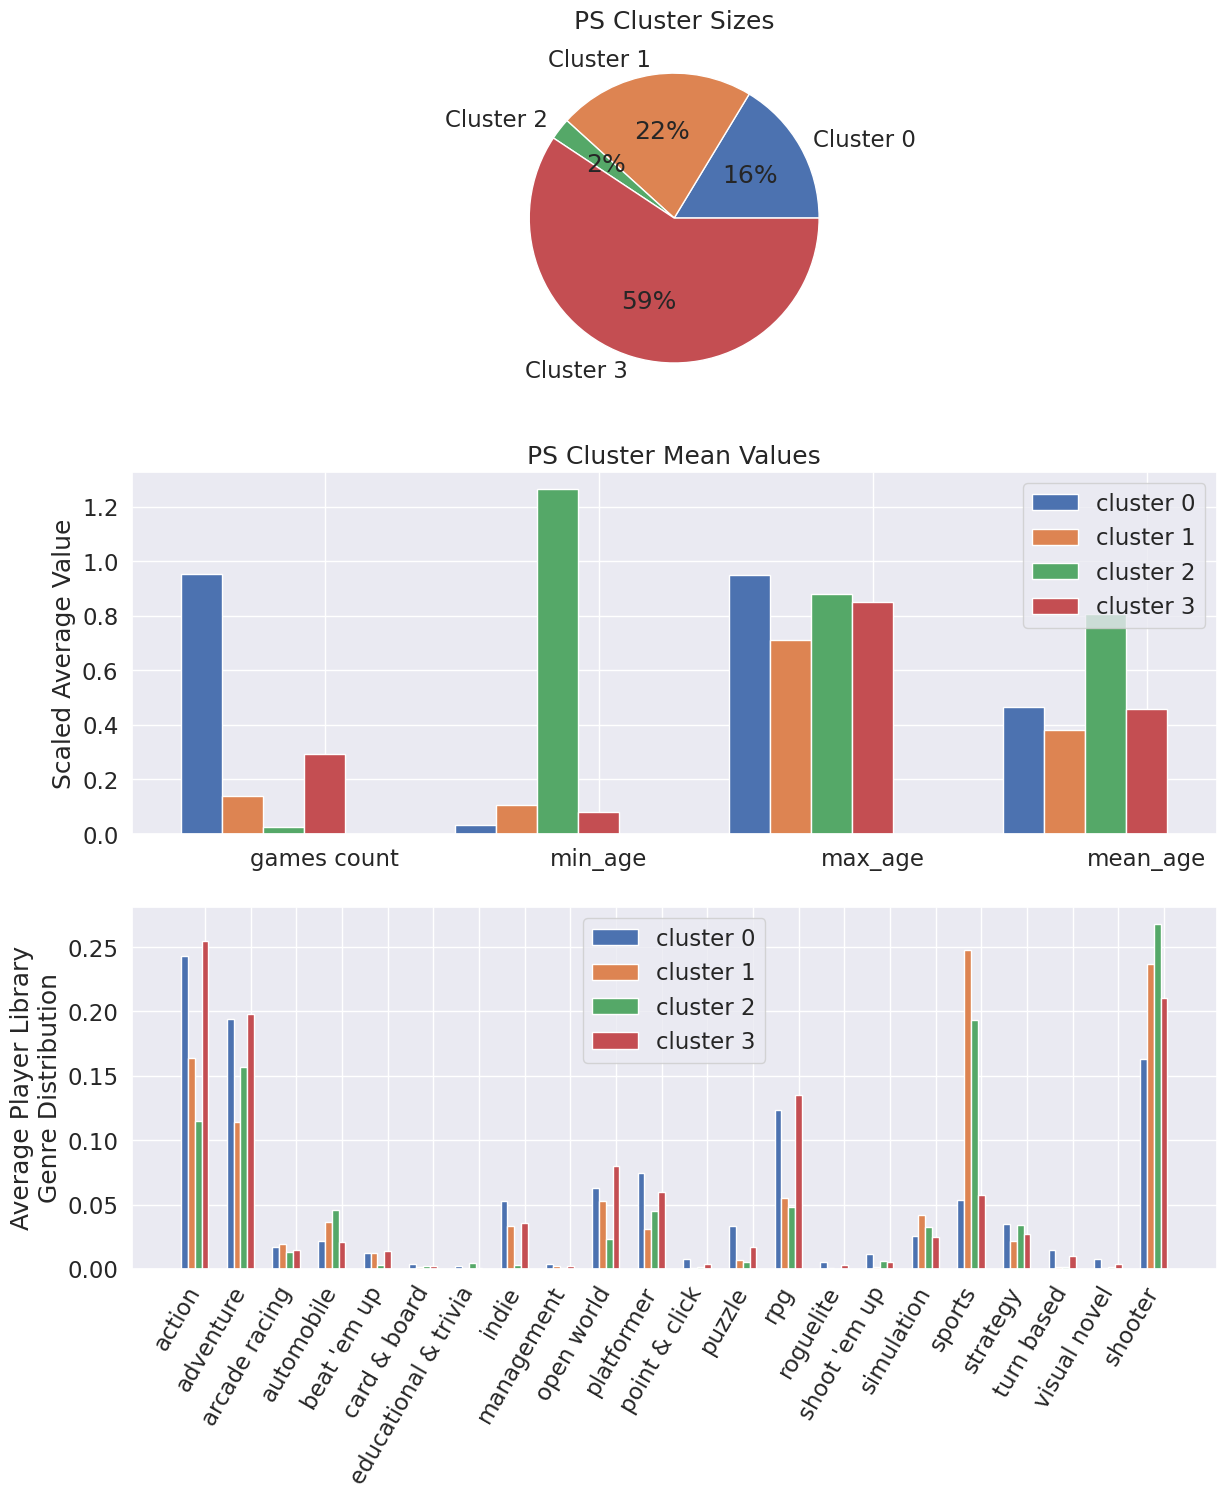

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

grouped = PS_player_char_T_C.groupby("cluster")["games count"].count()

axes[0].pie(grouped, labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], autopct='%1.0f%%')
axes[0].set_title("PS Cluster Sizes")

grouped = PS_player_char_T_C.groupby("cluster").mean().drop(PS_genres_refined, axis = 1)
width = 0.15
r = np.arange(4)
for i in range(k):
    axes[1].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[1].set_title("PS Cluster Mean Values")
axes[1].set_ylabel("Scaled Average Value")
axes[1].legend()

grouped = PS_player_char_C.groupby("cluster").mean()[PS_genres_refined]
width = 0.15
r = np.arange(22)
for i in range(k):
    axes[2].bar(x = [x + width*i for x in r], tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")
#     axes[2].bar(tick_label = grouped.columns, height = grouped.loc[i], width = width, label = f"cluster {i}")

axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=60, ha='right')
axes[2].set_ylabel("Average Player Library\nGenre Distribution")
axes[2].legend()

plt.show()

# Conclusion

## Steam Player Categorization

Given the use of four clusters in the categorical model, the model reveals four generalized player types.

**Type 1: "Freemium Player"** Owns few games and has a moderate number of friends. Most of the owned games are "Free To Play" suggesting that these players don't often purchase costly games. This is corroborated by the age statistics of their game library which shows that these players do not purchase newly released games which likely tend to be more expensive.

**Type 2: "Social Player"** Owns a significant number of games and has a very large number of friends. Many game genres allow of online/multiplayer experience meaning that there is no specific genre that attracts this type of player.

**Type 3: "Game Collector"** Largely characterized by their large game portfolios which contain some of the most recently released games as well as the oldest available games. The genre distribution of these players tends to be much more balanced with a slight focus on indie gaming, likely because so many small indie games are available on PC.

**Type 4: "Average Player"** There are no characteristics that stand out within this group. This is also the most common player type observed in this analysis.


## Xbox Player Categorization

**Type 1: "Game Collector"** Largely characterized by their large game portfolios which contain some of the most recently released games. The genre distribution of these players tends to be much more balanced than other player types.

**Type 2: "Mainstream Player"** These players own few games and tend to own mostly older games. Their collections primarily include top sellers across the popular genres such as sports and shooters. Despite the chosen naming convention, this player type is the smallest on the platform.

**Type 3: "Average Sports Player"** These players don't have many strong defining qualities except their tendency to lean towards sports, racing, and open world games.

**Type 4: "Average Shooter Player"** These players don't have many strong defining qualities except their tendency to lean towards action, adventure, and shooter games.

## Playstation Player Categorization

**Type 1: "Game Collector"** Largely characterized by their large game portfolios which contain some of the most recently released games as well as the oldest available games. Unlike other platforms, this player types tends to focus on non-shooter, action and adventure games.

**Type 2: "Mainstream Player"** These players own few games and tend to own mostly older games. Their collections primarily include top sellers across the popular genres such as sports and shooters. Despite the chosen naming convention, this player type is very small on this platform.

**Type 3: "Average Sports/Shooter Player"** These players don't have many strong defining qualities except their tendency to lean towards both sports and shooter games. This group is similar to Type 2 except that they purchase more newer games.

**Type 4: "Average Action/Adventure Player"** These players don't have many strong defining qualities except their tendency to lean towards non-shooter, action and adventure games. Other popular genres in this group are RPG, platformer, and open world games.

# Future Work

As mentioned previously, the dataset used for this analysis lacks many useful features. Even after feature engineering, there are a great number of player characteristics that are missing. This analysis could be greatly improved by accessing and utilizing player information that more directly measures player activity (such as a playtime metric). In particular, a more detailed analysis would likely lead to more accurate categorization.

The categorical model used for analysis made use of a reduced number of clusters (k = 4) for simplification. More niche player groups could be analyzed with additional clustering. In particular, some of the "average" player types which encompass most players could be easily broken into additional categories.